# CSPB 3022 Final Project: Part 1

##### Regression Project: Apartment Rent Prediction

**Jordon Young**


Data:

Apartment for rent classified. (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5X623.


In [1]:
import datetime as dt
import numpy as np 

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.basemap import Basemap

import pandas as pd 
from scipy.stats import pearsonr
import seaborn as sns
sns.set()

apartments = pd.read_csv("data/apartments_for_rent_classified_100K.csv", encoding="latin1", sep=";")

C:\Users\jordo\AppData\Local\Temp\ipykernel_3400\3047019091.py:13: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  apartments = pd.read_csv("data/apartments_for_rent_classified_100K.csv", encoding="latin1", sep=";")


## Univariate Exploration, Data Cleaning, and Processing


The data for this project comes from UC Irvine's Machine Learning Repository: [Apartment for Rent Classifieds](https://doi.org/10.24432/C5X623). It has a CVS file with either 10k or 100k samples. I'm choosing to use 100k samples so there is plenty of data to divide up for training and testing.

The data currently has 22 columns with a condition that `price` and `square_feet` are never empty.

In an attempt to make things easy to follow, I have all exploration, cleaning, and univariate analysis located in one place. I've included basic processing as an exercise to understand the data, but my intention is not to create new features at this point. My goal is to understand what I've been given, think about how I can use it, and remove data that is nonsense or unusable.


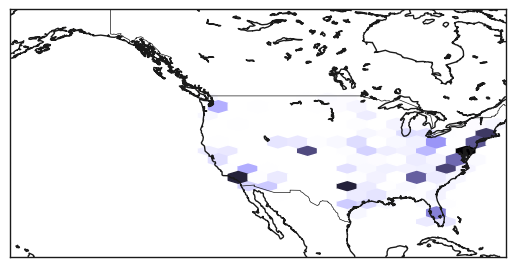

In [2]:
"""Plot apartment locations on map"""

# Remove rows with NaN values in the latitude or longitude columns
locations = apartments[["latitude", "longitude"]].dropna()

# Create a figure and axes
fig, ax = plt.subplots()

# Calculate the minimum and maximum longitude and latitude values
lon_min, lon_max = locations['longitude'].min(), locations['longitude'].max()
lat_min, lat_max = locations['latitude'].min(), locations['latitude'].max()

# Create a Basemap centered at the mean latitude and longitude of the locations
map = Basemap(
    projection='cyl',
    llcrnrlon=lon_min,
    llcrnrlat=lat_min,
    urcrnrlon=lon_max,
    urcrnrlat=lat_max,
    resolution='l',
    ax=ax
)

# Draw coastlines and country boundaries
map.drawcoastlines()
map.drawcountries()

# Set the background color of the map to white
map.drawmapboundary(fill_color='white')

# Create a custom colormap with three colors
cmap = LinearSegmentedColormap.from_list('custom', ['#fff', '#9f9aff', "#484272", '#030205'])

# Plot the longitude and latitude pairs as a density plot on the map
x, y = map(locations['longitude'].values, locations['latitude'].values)
map.hexbin(x, y, gridsize=25, cmap=cmap)

# Show the plot
plt.show()

In [3]:
apartments.columns.values.tolist()

['id',
 'category',
 'title',
 'body',
 'amenities',
 'bathrooms',
 'bedrooms',
 'currency',
 'fee',
 'has_photo',
 'pets_allowed',
 'price',
 'price_display',
 'price_type',
 'square_feet',
 'address',
 'cityname',
 'state',
 'latitude',
 'longitude',
 'source',
 'time']

#### `id`: nominal categorical

While represented as int64, these values are intended to be unique identifiers for listings. They are clearly 84 records that are not unique. I will drop duplicate rows.


In [4]:
id = apartments["id"]
print("Unique ids:", id.unique().size)
print("Total id records:", id.size)

Unique ids: 99408
Total id records: 99492


In [5]:
apartments = apartments[~apartments.duplicated()]
print("Unique ids:", apartments['id'].unique().size)
print("Total id records:", apartments['id'].size)

Unique ids: 99408
Total id records: 99408


In [6]:
apartments = apartments.drop(['id'], axis=1)

#### `category`: nominal categorical

It's not clear to me why there are redundant prefixes on these categories, or why the rental duration would be merged into the same variable as the type of building.

The only category of interest is `housing/rent/apartment`. The rest are extremely infrequent, so I'm going to drop them and focus on appartments only.


In [7]:
category = apartments["category"]
category.unique()

array(['housing/rent/apartment', 'housing/rent/home',
       'housing/rent/short_term', 'housing/rent', 'housing/rent/condo',
       'housing/rent/other', 'housing/rent/commercial/retail'],
      dtype=object)

In [8]:
category.value_counts()

category
housing/rent/apartment            99347
housing/rent/commercial/retail       42
housing/rent                          7
housing/rent/home                     4
housing/rent/short_term               4
housing/rent/condo                    3
housing/rent/other                    1
Name: count, dtype: int64

In [9]:
apartments = apartments[apartments['category'] == 'housing/rent/apartment']
apartments['category'].value_counts()

category
housing/rent/apartment    99347
Name: count, dtype: int64

In [10]:
apartments = apartments.drop(['category'], axis=1)

#### `title`: auxiliary information

The title variable appears to contain a wide range of styles and information. This is not immediately useful as a nominal categorical variable, but if processed, new attributes for each record could be created to add context to the listings. Every record has a title of some sort.


In [11]:
title = apartments["title"]
np.random.choice(title, 20).tolist()

['Three BR Apartment in Quiet Building - Las Vegas',
 'One BR - APARTMENT LIVING IN NORFOLK.',
 'Three BR Apartment - This charming Berwyn.',
 'Lovely One BR Apartment For Rent in Lovely South Location',
 'Welcome to the scenic country setting of historic Woodstock. $898/mo',
 "One BR Apartment - Just off one of Massachusetts' major highways.",
 'Prominence Apartments One BR Luxury Apartment Homes',
 'City of Verona Value!',
 'Two Spacious BR in Port St Lucie',
 'Three BR 501 Homey Drive',
 'Over 636 sf in Dallas. Single Car Garage!',
 'Convenient location One BR One BA for rent. Single Car Garage!',
 'Welcome to Silver Oak Apartments.',
 'Apartment in prime location',
 '$895 / One BR - Great Deal. MUST SEE!',
 'Amazing One BR, One BA for rent. Pet OK!',
 'Apartment - come and see this one.',
 'A choice downtown location in a park like setting. Pet OK!',
 'The Best of the Best in the City of Lilburn! Save Big!',
 'Two BR Apartment - This beautiful light, bright.']

In [12]:
# There are no NaN values
title.isna().value_counts() / title.size

title
False    1.0
Name: count, dtype: float64

In [13]:
max_title_len = float('-inf')
min_title_len = float('inf')
title_lens = []
for t in title.tolist():
    title_lens.append(len(t))
    if len(t) < min_title_len:
        min_title_len = len(t)
    if len(t) > max_title_len:
        max_title_len = len(t)

print("Minimum Title Length:", min_title_len)
print("Maximum Title Length:", max_title_len)
print("Average Title Length:", np.mean(title_lens))
print("Median Title Length", np.median(title_lens))

Minimum Title Length: 3
Maximum Title Length: 80
Average Title Length: 43.4896373317765
Median Title Length 42.0


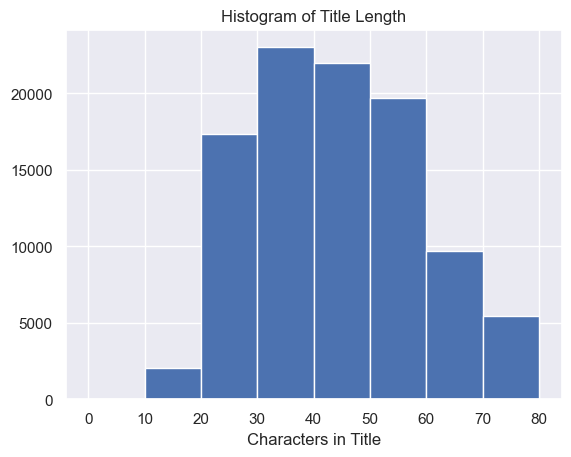

In [14]:
plt.hist(title_lens, bins=8, range=(0, 80))
plt.title("Histogram of Title Length")
plt.xlabel("Characters in Title")
plt.xticks(np.arange(0, 81, 10))
plt.show()

#### `body`: auxiliary information

Just like the title variable, the body variable contains a ton of extra information. It appears that often location, rent, and amenities are included in the description. If we are missing values for a record, it would be very helpful to be able to parse the tile and body to fill in missing information or add additional attributes gleaned from the description.


In [15]:
body = apartments["body"]
np.random.choice(body, 10).tolist()

['The historic integrity of the units has been maintained, along-side new granite and stainless steel finishes. Adjacent to DAAP and Good Samaritan Hospital, this is the perfect location for West campus students.',
 'This unit is located at twelve Chester St, Allston, 02134, MAMonthly rental rates range from $4500We have 5 beds units available for rent',
 'Square footage: 1240 sq-ft, unit number: 3123. Welcome to Avanti Perfectly placed in Centennial Hills, Avanti Apartment offers panoramic views of the Las Vegas Valley and Mount Charleston! Just off the Bruce Woodbury Beltway/215, Avanti has commuting accessibility to all areas of the valley, as well as proximity to shopping, dining, and healthcare. Avanti has the ideal balance of city excitement and the serenity that comes from being close to nature. Just five minutes from Red Rock Conservation Area, residents of Centennial Hills enjoy access to countless miles of hiking trails, skiing and snowboarding in winter, golf courses, and sc

In [16]:
# There are no NaN values
body.isna().value_counts() / body.size

body
False    1.0
Name: count, dtype: float64

In [17]:
max_body_lens = float('-inf')
min_body_lens = float('inf')
body_lens = []
for b in body.tolist():
    body_lens.append(len(b))
    if len(b) < min_body_lens:
        min_body_lens = len(b)
    if len(b) > max_body_lens:
        max_body_lens = len(b)

print("Minimum Body Length:", min_body_lens) # There are no empty strings
print("Maximum Body Length:", max_body_lens)
print("Average Body Length:", np.mean(body_lens))
print("Median Body Length", np.median(body_lens))

Minimum Body Length: 6
Maximum Body Length: 315288
Average Body Length: 805.8535537056982
Median Body Length 921.0


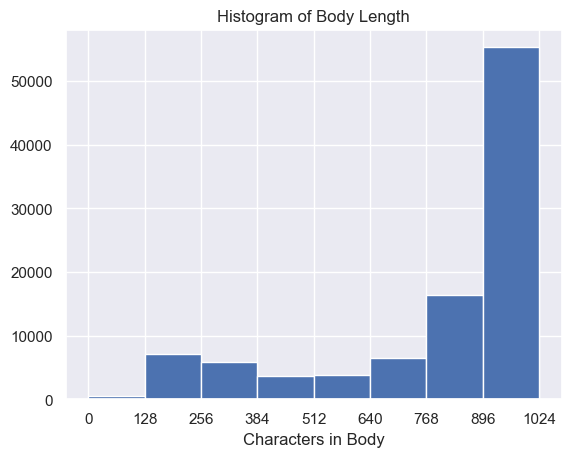

In [18]:
plt.hist(body_lens, bins=8, range=(0, 1024))
plt.title("Histogram of Body Length")
plt.xlabel("Characters in Body")
plt.xticks(np.arange(0, 1025, 128))
plt.show()

#### `amenities`: auxiliary information

There's a lot of work that needs to be done to process the amenities information, which is essentially a variable containing comma separated values. It is definitely helpful information, but the format is problematic because I can't compare or contrast them as they are. The only question I can answer is whether they have amenities and how long the string is. Even rentals without listed amenities have amenities, so this will be an interesting variable to investigate.


In [19]:
amenities = apartments["amenities"]
np.random.choice(amenities, 10).tolist()

[nan,
 'Clubhouse,Gym,Playground,Pool,Storage,Tennis,Wood Floors',
 'Gym,Internet Access,Parking,Pool,Washer Dryer',
 'Parking',
 'Gated,Wood Floors',
 nan,
 'Storage',
 'Parking,Pool',
 'Dishwasher,Parking,Pool,Washer Dryer,Wood Floors',
 'Gym,Playground,Pool,TV,Tennis,Washer Dryer']

In [20]:
amenities.isna().value_counts() / amenities.size

amenities
False    0.838626
True     0.161374
Name: count, dtype: float64

As an exploration, I've gone through and extracted the possible values found in the amenities column. When processing the data, I will likely create a new column for each of the amenities as a feature, and search through the titles and descriptions to see if these words appear. The format is somewhat inconsistent. Some keys have slashes, contractions, or spaces that are part of the amenity name.


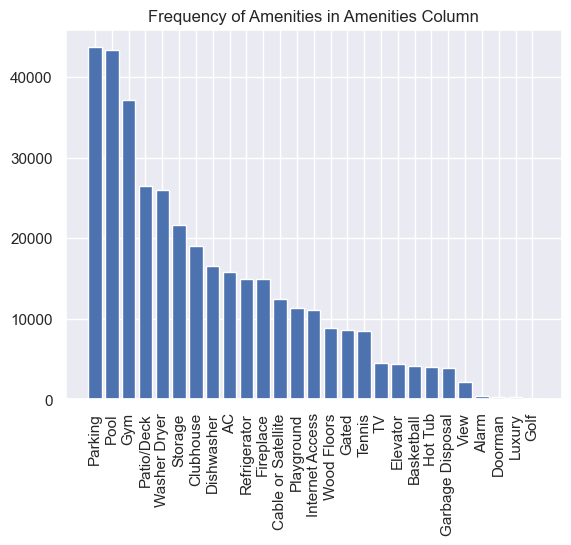

In [21]:
bag_of_amenities = {}

for amenity_list in amenities.dropna().tolist():
    words = amenity_list.split(',')
    for word in words:
        word = word.strip()
        if word in bag_of_amenities:
            bag_of_amenities[word] += 1
        else:
            bag_of_amenities[word] = 1

amenities_processed = pd.Series(bag_of_amenities).sort_values(ascending=False)

plt.bar(x=amenities_processed.index, height=amenities_processed.values)
plt.xticks(rotation=90)
plt.title("Frequency of Amenities in Amenities Column")
plt.show()

#### `bathrooms`: numerical discrete

The values range from 1.0 to 9.0, including the possibility of NaN. It looks like very few of the records are NaN, so I'm going to drop them.


In [22]:
bathrooms = apartments["bathrooms"]
bathrooms.value_counts().sort_index()

bathrooms
1.0    56230
1.5     3165
2.0    36514
2.5     2078
3.0      888
3.5      208
4.0      120
4.5       42
5.0       20
5.5        4
6.0        8
7.0        3
7.5        1
8.0        2
8.5        1
9.0        1
Name: count, dtype: int64

In [23]:
bathrooms.isna().value_counts() / bathrooms.size

bathrooms
False    0.999376
True     0.000624
Name: count, dtype: float64

In [24]:
apartments = apartments[apartments['bathrooms'].notna()]
apartments['bathrooms'].isna().value_counts() / apartments['bathrooms'].size

bathrooms
False    1.0
Name: count, dtype: float64

In [25]:
bathrooms = apartments["bathrooms"]

print("Minimum Bathrooms:", bathrooms.min())
print("Maximum Bathrooms:", bathrooms.max())
print("Mean Bathrooms:", bathrooms.mean())
print("Median Bathrooms", bathrooms.median())

Minimum Bathrooms: 1.0
Maximum Bathrooms: 9.0
Mean Bathrooms: 1.445268670997633
Median Bathrooms 1.0


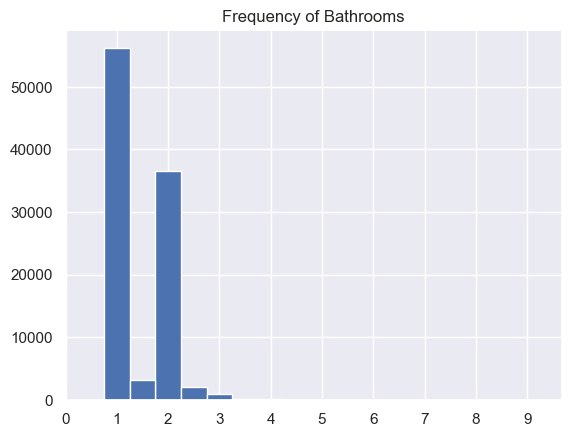

In [26]:
bathroom_counts = bathrooms.value_counts()
bathroom_counts.sort_index()

plt.bar(x=bathroom_counts.index, height=bathroom_counts, width=0.5)
plt.title("Frequency of Bathrooms")
plt.xticks(np.arange(0,10,1))
plt.show()

#### `bedrooms`: numerical discrete

Nan in the context of a bedroom could either mean a studio or missing information. A bedroom count of 0 is certainly a studio, but NaN is problematic. Luckily very few of the records have NaN for bedrooms, so I'm going to drop them.


In [27]:
bedrooms = apartments["bedrooms"]
bedrooms.value_counts().sort_index()

bedrooms
0.0      645
1.0    40251
2.0    45891
3.0    10538
4.0     1498
5.0      285
6.0       46
7.0        4
8.0        3
9.0        1
Name: count, dtype: int64

In [28]:
bedrooms.isna().value_counts() / bedrooms.size

bedrooms
False    0.998761
True     0.001239
Name: count, dtype: float64

In [29]:
apartments = apartments[apartments['bedrooms'].notna()]
apartments['bedrooms'] = apartments['bedrooms'].astype('int64')

apartments['bedrooms'].isna().value_counts() / apartments['bedrooms'].size

bedrooms
False    1.0
Name: count, dtype: float64

In [30]:
bedrooms = apartments["bedrooms"]

print("Minimum Bedrooms:", bedrooms.min())
print("Maximum Bedrooms:", bedrooms.max())
print("Mean Bedrooms:", bedrooms.mean())
print("Median Bedrooms", bedrooms.median())

Minimum Bedrooms: 0
Maximum Bedrooms: 9
Mean Bedrooms: 1.7284947863092717
Median Bedrooms 2.0


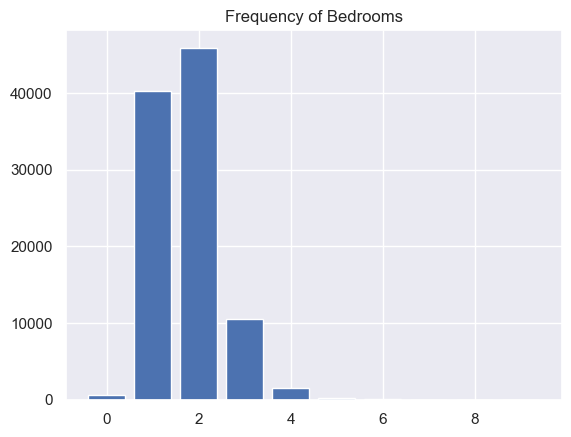

In [31]:
bedroom_counts = bedrooms.value_counts()
bedroom_counts.sort_index()

plt.bar(x=bedroom_counts.index, height=bedroom_counts)
plt.title("Frequency of Bedrooms")
plt.show()

#### `currency`: nominal categorical

The only value for currency in this dataset is USD, so I'm going to drop it.


In [32]:
currency = apartments["currency"]
currency.unique().tolist()

['USD']

In [33]:
apartments = apartments.drop(['currency'], axis=1)

#### `fee`: nominal categorical

This variable doesn't make sense to me, and the only description given by on the source website is that this is a `fee`. It looks like less than 2% charge a fee. This isn't a variable I want to explore further, so I'm going to remove the `Yes` fees and drop the column.


In [34]:
fee = apartments["fee"]
fee.value_counts() / fee.size

fee
No     0.998013
Yes    0.001987
Name: count, dtype: float64

In [35]:
apartments = apartments[apartments['fee'] == 'No']
apartments = apartments.drop(['fee'], axis=1)

#### `has_photo`: categorical

This is a strange variable. It sounds like it would be boolean, but it actually has three categories. What's the difference between `Thumbnail` and `Yes`? If a record has `Yes`, does that mean it also had a `thumbnail`? This variable seems like it would contain a lot of incorrectly assigned values. Since I'm not sure what it means, I can't draw conclusions from analyzing it. I'll drop it.


In [36]:
has_photo = apartments["has_photo"]
has_photo.value_counts()

has_photo
Yes          55798
Thumbnail    33996
No            9171
Name: count, dtype: int64

In [37]:
apartments = apartments.drop(['has_photo'], axis=1)

#### `pets_allowed`: categorical

It seems like there is a natural ordering progressing from no pets to cats to dogs to cats and dogs. It's an abstracted scale of pet friendliness, but I don't know how useful it will be in its current state. I don't agree with the use of NaN here because in most contexts it suggests missing data. What is 'Cats,Dogs,None'? I'll take that to mean an option. I'm going to replace it with `True` for pets_allowed and `False` for pets not allowed.


In [38]:
pets_allowed = apartments["pets_allowed"]
pets_allowed.unique().tolist()

['Cats', 'Cats,Dogs', nan, 'Dogs', 'Cats,Dogs,None']

In [39]:
pets_allowed = pets_allowed.replace('Cats', True)
pets_allowed = pets_allowed.replace('Dogs', True)
pets_allowed = pets_allowed.replace('Cats,Dogs', True)
pets_allowed = pets_allowed.replace('Cats,Dogs,None', True)
pets_allowed = pets_allowed.fillna(False)
pets_allowed = pets_allowed.astype(bool)

apartments['pets_allowed'] = pets_allowed
apartments['pets_allowed'].value_counts()

pets_allowed
False    60039
True     38926
Name: count, dtype: int64

In [40]:
pets_allowed.value_counts().sum() # Expected number of true

98965

#### `price`: numerical discrete

This is the price per installment. Read on for an explanation of what I mean by installments. There is one NaN value. I'm going to remove it and cast the whole thing to integers since that's what they are.


In [41]:
price = apartments["price"]
np.random.choice(price, 10).tolist()

[509.0, 1899.0, 1275.0, 915.0, 1223.0, 1200.0, 1100.0, 1775.0, 675.0, 3486.0]

In [42]:
price.isna().value_counts()

price
False    98964
True         1
Name: count, dtype: int64

In [43]:
apartments = apartments[apartments['price'].notna()]
apartments['price'] = apartments['price'].astype(int)
apartments['price'].describe()

count    98964.000000
mean      1526.255962
std        899.047976
min        200.000000
25%       1015.000000
50%       1350.000000
75%       1795.000000
max      52500.000000
Name: price, dtype: float64

#### `price_display`: mixed / improper format

The price is guaranteed to exist for every record. This appears to be a human friendly string representation of the price per installment, so I'm going to drop it. It's entirely redundant.


In [44]:
price_display = apartments["price_display"]
np.random.choice(price_display, 5).tolist()

['$2,150', '$958', '$2,119', '$2,863', '$1,567']

In [45]:
apartments = apartments.drop(['price_display'], axis=1)

#### `price_type`: categorical

This is the installment type, or frequency of payment. The hybrid category of `Monthly|Weekly` allows either, but does not clearly describe what frequency is used in the `price` variable (depending on how data is cleaned before this point, these records may have already been removed for another reason).

It might help to "normalize" the price variable by converting everything to monthly, but since there are only three I'll drop them as outliers. Specifically, I'll drop those three rows and remove the column.


In [46]:
price_type = apartments["price_type"]
price_type.value_counts()

price_type
Monthly    98961
Weekly         3
Name: count, dtype: int64

In [47]:
apartments = apartments[apartments['price_type'] == 'Monthly']
apartments['price_type'].value_counts()

price_type
Monthly    98961
Name: count, dtype: int64

In [48]:
apartments = apartments.drop(['price_type'], axis=1)

#### `square_feet`: numerical discrete

Besides price, this is the only other variable guaranteed to have a non-NaN value besides price.


In [49]:
square_feet = apartments["square_feet"]
np.random.choice(square_feet, 10).tolist()

[692, 714, 958, 900, 897, 1173, 800, 980, 1045, 684]

In [50]:
square_feet.describe()

count    98961.000000
mean       955.942078
std        365.141823
min        107.000000
25%        730.000000
50%        900.000000
75%       1115.000000
max      12000.000000
Name: square_feet, dtype: float64

#### `address`: nominal categorical

This is only the street address of the listing. It could be NaN. I don't think I'll use it for my project since I'm not clustering.


In [51]:
address = apartments["address"]
np.random.choice(address, 5).tolist()

[nan, nan, nan, nan, nan]

In [52]:
address.isna().value_counts()

address
True     91174
False     7787
Name: count, dtype: int64

#### `cityname`: nominal categorical

It's the name of the city for the listing. It could be NaN.


In [53]:
cityname = apartments["cityname"]
np.random.choice(cityname, 5).tolist()

['Liverpool', 'Malibu', 'Canal Winchester', 'Knightdale', 'Las Vegas']

In [54]:
cityname.isna().value_counts()

cityname
False    98663
True       298
Name: count, dtype: int64

#### `state`: nominal categorical

It's the name of the state for the listing. It could be NaN.


In [55]:
state = apartments["state"]
np.random.choice(state, 10).tolist()

['TN', 'VA', 'TX', 'NJ', 'CO', 'MT', 'NC', 'NE', 'MO', 'CA']

In [56]:
state.isna().value_counts()

state
False    98663
True       298
Name: count, dtype: int64

In [57]:
state.value_counts()

state
TX    11219
CA    10237
VA     8264
NC     6289
CO     6267
FL     5761
MD     5229
MA     4924
OH     4889
GA     4743
NJ     4432
NV     2810
WA     2591
AZ     2368
LA     1344
MO     1201
PA     1114
TN     1111
IL     1026
NE     1019
KY      985
OK      931
SC      906
KS      891
UT      809
ND      739
NH      733
MI      709
NY      649
AR      597
MN      578
CT      504
IN      500
WI      428
IA      371
AL      351
OR      276
VT      125
RI      119
MS      107
ID       90
MT       87
SD       85
DC       83
AK       57
HI       31
ME       28
NM       22
WY       16
WV       12
DE        6
Name: count, dtype: int64

#### `latitude` and `longitude`: numerical continuous

The location of the listing. I used it at the top of the document to plot listings on a map. If clustering, it would be much better to use `latitude` and `longitude` than address/city/state because of missing information there.


In [58]:
latitude = apartments["latitude"]
np.random.choice(latitude, 5).tolist()

[27.8597, 33.0308, 33.8737, 38.8967, 40.748]

In [59]:
longitude = apartments["longitude"]
np.random.choice(longitude, 5).tolist()

[-84.5394, -76.8511, -80.1911, -81.5295, -117.0855]

In [60]:
latitude.isna().value_counts()

latitude
False    98936
True        25
Name: count, dtype: int64

In [61]:
longitude.isna().value_counts()

longitude
False    98936
True        25
Name: count, dtype: int64

#### `source`: nominal categorical

Each record is a listing scraped from the internet. The source website can be found in this variable. It's interesting to see the names of the source websites as they are far from the most popular sites in the US (examples: Zillow, Apartments.com, Rent.com).

It might be wise to remove all sources from RENTCafe onward, but for now I'll leave them all and show a few samples.


In [62]:
source = apartments['source']
source.value_counts()

source
RentDigs.com         90661
RentLingo             6891
ListedBuy              553
GoSection8             434
RealRentals            268
RENTCafé                41
Listanza                25
RENTOCULAR              18
tenantcloud             17
RentFeeder              12
Home Rentals             8
SpreadMyAd               7
rentbits                 5
vFlyer                   5
Claz                     4
Nest Seekers             3
Seattle Rentals          2
Real Estate Agent        1
Real Estate Shows        1
Apartable                1
Z57                      1
FreeAdsTime              1
AgentWebsite             1
HousesForRent            1
Name: count, dtype: int64

In [63]:
apartments[apartments['source'] == 'RENTCafé'].head()

,title,body,amenities,bathrooms,bedrooms,pets_allowed,price,square_feet,address,cityname,state,latitude,longitude,source,time
7112,The Oasis - B1,"Oasis is located at 9690 Forest Lane Dallas, T...",AC,1.0,2,True,995,875,9690 Forest Ln,Dallas,TX,32.9108,-96.7321,RENTCafé,1576253157
50409,Modera Metro Dadeland West - West-A02,Receive waived app and admin charges on all ho...,NaN,1.0,1,True,1782,639,8215 S.W 72nd Avenue,Miami,FL,25.7028,-80.2974,RENTCafé,1565878583
50410,Modera Metro Dadeland West - West-B06,Receive waived app and admin charges on all ho...,NaN,2.0,2,True,2882,1328,8215 S.W 72nd Avenue,Miami,FL,25.7028,-80.2974,RENTCafé,1565878595
50427,Oakton Park Apartments - One BR (1B),"Oakton Park offers beautiful one, 2 and 3 beds...","Patio/Deck,Pool,Washer Dryer,Wood Floors",1.0,1,True,1660,746,3347 Willow Crescent Dr,Fairfax,VA,38.8361,-77.3389,RENTCafé,1567176759
50428,2817 E 77th St - Two BR One BA Apartment,"This seven-plex in South Shore, Chicago featur...","Cable or Satellite,Wood Floors",1.0,2,True,810,800,2817 E 77th St,Chicago,IL,41.7620,-87.5704,RENTCafé,1567264754


#### `time`: numerical discrete

The timestamp the record was pulled from the source. It is in POSIX / UNIX format. It might be helpful to convert to datetime.


In [64]:
time = apartments['time']
time.describe()

count    9.896100e+04
mean     1.559627e+09
std      1.104604e+07
min      1.544174e+09
25%      1.550832e+09
50%      1.568745e+09
75%      1.568767e+09
max      1.577361e+09
Name: time, dtype: float64

### Post Cleaning

After all that cleaning, I'm down to 15 columns instead of 22 columns. I only removed the data which was nonsense or redundant. I have no intention of using the location information, but it would be reasonable to use.

Even though I removed bad data, I haven't processed the title, body, and amenities columns and extracted them into features. This seems like a complex task, so for now I will make use of the data that I can immediately work with. For those reasons, I'm going to remove a bunch more columns simply to hone in on the problem.


In [65]:
apartments.head()

,title,body,amenities,bathrooms,bedrooms,pets_allowed,price,square_feet,address,cityname,state,latitude,longitude,source,time
0,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1,True,2195,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1577360355
1,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3,True,1250,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1577360340
2,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,NaN,2.0,3,False,1395,1650,3101 Morningside Dr,Raleigh,NC,35.8230,-78.6438,RentLingo,1577360332
3,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",NaN,1.0,2,True,1600,820,209 Aegean Way,Vacaville,CA,38.3622,-121.9712,RentLingo,1577360330
4,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",NaN,1.0,1,True,975,624,4805 Marquette NE,Albuquerque,NM,35.1038,-106.6110,RentLingo,1577360308


In [66]:
apartments = apartments.drop(['title', 'body', 'amenities', 'address', 'cityname', 'state', 'latitude', 'longitude', 'time'], axis=1)

## Project Topic

For this project, I would like to solve a regression problem. Given information about a few variables, I would like to be able to estimate the monthly rental price.

More specifically, given:

- Number of bedrooms
- Number of bathrooms
- Whether pets are allowed
- Number of square feet

Predict the monthly rent.

I will set aside a random portion of my data to use as test data, since this information is localized and trained on data from a few years ago. I assume it would not be able to give an accurate prediction anywhere in the country, taking into account inflation, but it should be accurate with its own test data (since most of the data comes from a few cities).

My motivation for this project is to do something achievable and explore data science and machine learning concepts. When I have the core down, I would like to amp up the complexity and transform the text field data into usable features. From there, I should be able to give much better predictions based on the types of information consumers expect to see (lists of amenities).


In [67]:
apartments.head()

,bathrooms,bedrooms,pets_allowed,price,square_feet,source
0,1.0,1,True,2195,542,RentLingo
1,1.5,3,True,1250,1500,RentLingo
2,2.0,3,False,1395,1650,RentLingo
3,1.0,2,True,1600,820,RentLingo
4,1.0,1,True,975,624,RentLingo


## Beginning Multivariate Analysis


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


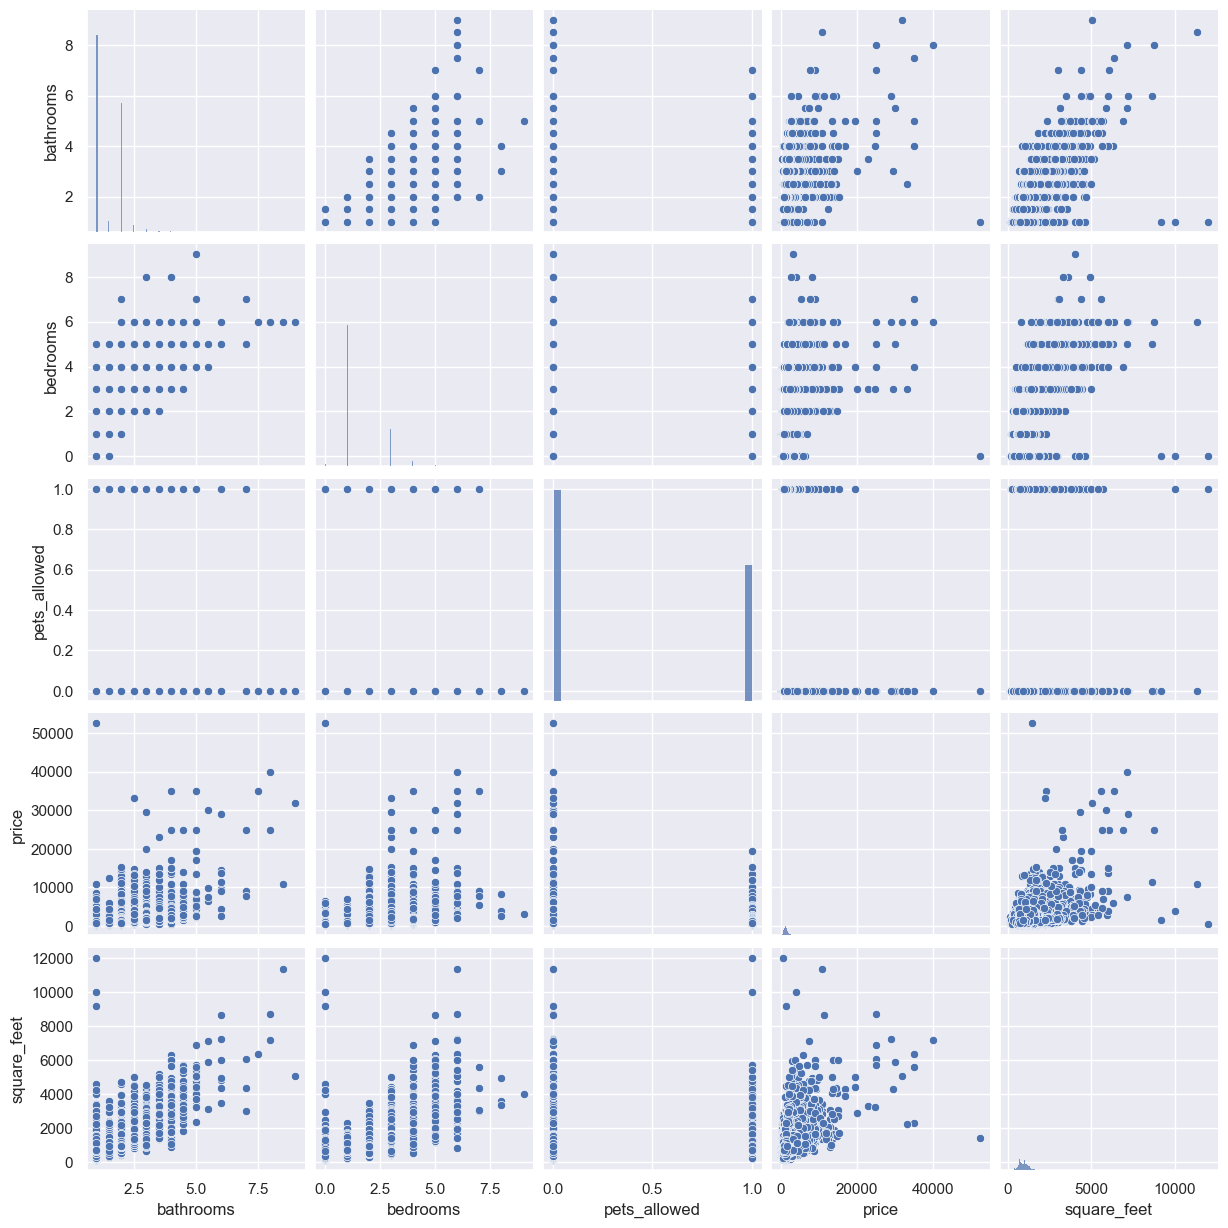

In [68]:
sns.pairplot(apartments);

Immediately from this pair-plot there are some obvious associations:

Positive associations:

- square_feet and bathrooms
- square_feet and bedrooms
- square_feet and price
- bedrooms and bathrooms

Negative associations:

- square_feet and pets_allowed (first glance judgement, could be wrong)

None of the positive associations are shocking to me—generally more space is divided into more bed/bathrooms, and that cost more. I'm not sure if I'm reading the plot correctly, but it looks like larger apartments (probably more expensive apartments) do not allow pets.

Let's investigate further...


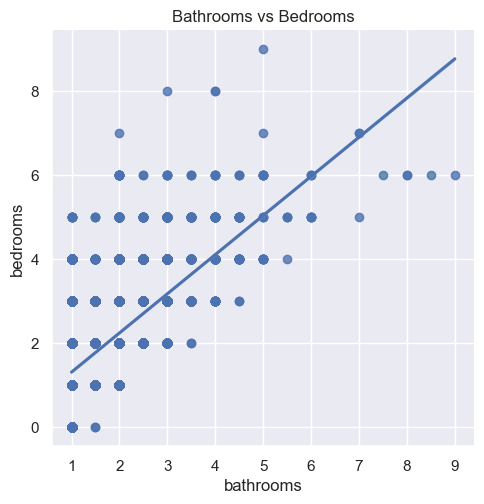

Correlation coefficient: 0.68




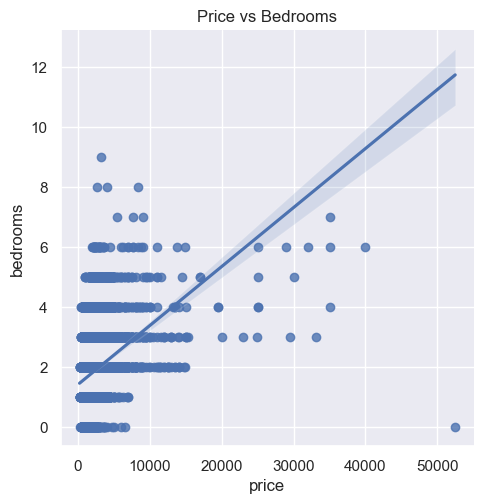

Correlation coefficient: 0.24




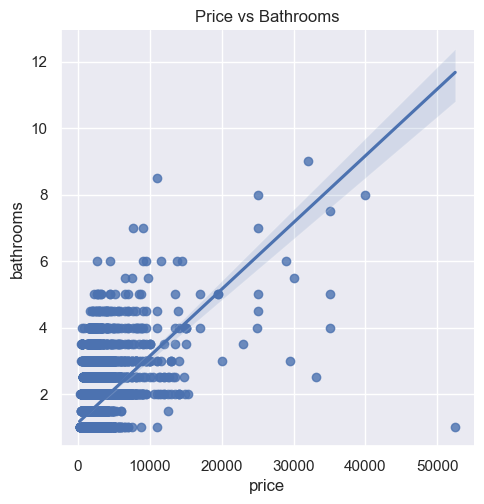

Correlation coefficient: 0.33




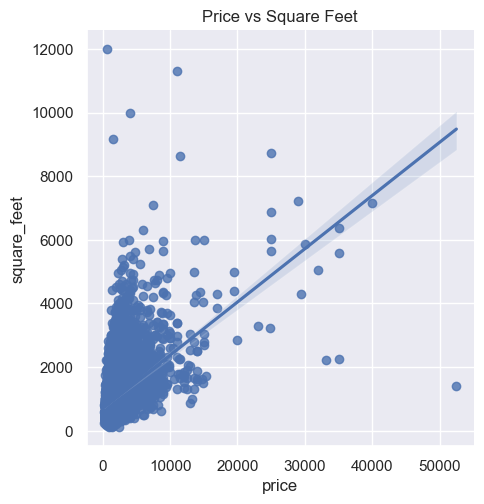

Correlation coefficient: 0.41




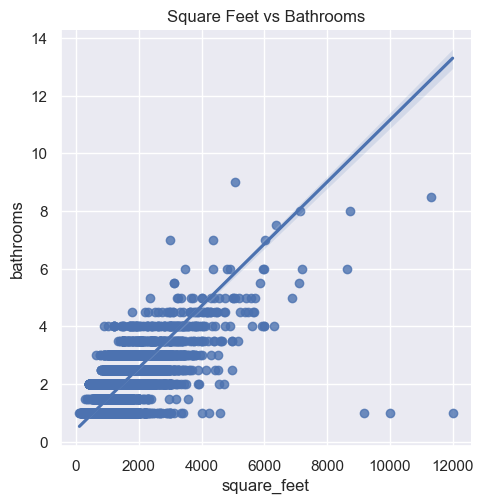

Correlation coefficient: 0.72




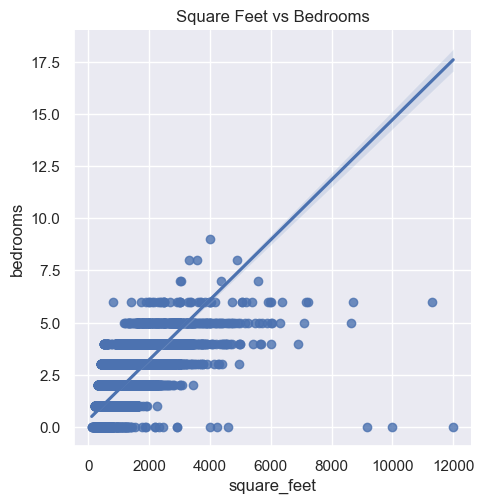

Correlation coefficient: 0.70




In [69]:
# bathrooms vs bedrooms
sns.lmplot(data=apartments, x='bathrooms', y='bedrooms')
plt.title('Bathrooms vs Bedrooms')
plt.show()
corr, _ = pearsonr(apartments['bathrooms'], apartments['bedrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# price vs bedrooms
sns.lmplot(data=apartments, x='price', y='bedrooms')
plt.title('Price vs Bedrooms')
plt.show()
corr, _ = pearsonr(apartments['price'], apartments['bedrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# price vs bathrooms
sns.lmplot(data=apartments, x='price', y='bathrooms')
plt.title('Price vs Bathrooms')
plt.show()
corr, _ = pearsonr(apartments['price'], apartments['bathrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# price vs square_feet
sns.lmplot(data=apartments, x='price', y='square_feet')
plt.title('Price vs Square Feet')
plt.show()
corr, _ = pearsonr(apartments['price'], apartments['square_feet'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# square_feet vs bathrooms
sns.lmplot(data=apartments, x='square_feet', y='bathrooms')
plt.title('Square Feet vs Bathrooms')
plt.show()
corr, _ = pearsonr(apartments['square_feet'], apartments['bathrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

# square_feet vs bedrooms
sns.lmplot(data=apartments, x='square_feet', y='bedrooms')
plt.title('Square Feet vs Bedrooms')
plt.show()
corr, _ = pearsonr(apartments['square_feet'], apartments['bedrooms'])
print(f'Correlation coefficient: {corr:.2f}\n\n')

Looking at the plots above, the correlation between bedrooms/bathrooms vs price is between 0.24-0.3, but the correlation of square_foot and price is 0.4.

Additionally, there is a much stronger correlation, around 0.7 between bedrooms/bathrooms and square_feet, which makes complete sense.


In [70]:
# for apartments that accept pets
pets = apartments[apartments['pets_allowed'] == 1]
print(pets.describe())

# for apartments that don't accept pets
no_pets = apartments[apartments['pets_allowed'] == 0]
print(no_pets.describe())

          bathrooms      bedrooms         price   square_feet
count  38924.000000  38924.000000  38924.000000  38924.000000
mean       1.439806      1.705426   1463.947719    936.841537
std        0.531597      0.729725    707.594714    332.129023
min        1.000000      0.000000    285.000000    200.000000
25%        1.000000      1.000000   1009.000000    720.000000
50%        1.000000      2.000000   1309.000000    896.000000
75%        2.000000      2.000000   1712.250000   1100.000000
max        7.000000      7.000000  19500.000000  12000.000000
          bathrooms      bedrooms         price   square_feet
count  60037.000000  60037.000000  60037.000000  60037.000000
mean       1.449948      1.742825   1566.547029    968.325599
std        0.556820      0.759720   1001.402304    384.531724
min        1.000000      0.000000    200.000000    107.000000
25%        1.000000      1.000000   1019.000000    735.000000
50%        1.000000      2.000000   1385.000000    909.000000
75%     

Getting a sense for what the average listing that accepts pets or doesn't accept pets is listed above. It appears that they are mostly the same, but an average apartment from the no pets section has a mean monthly rent of $100 higher and around 30 additional square feet. It would take more investigation to see whether there are outliers impacting the mean.

I think this is enough for now in part 1. There is a ton of data here that I haven't been able to look at yet, but as we continue with the course, I can continue adding more. I'm particularly excited to process the title, body, and amenities. It would be interesting to see how much each feature contributes to the price of the apartment. Being able to create a model based on more than a handful of variables should give much more accurate predictions, at least within this test data.
